<a href="https://colab.research.google.com/github/saschaschworm/dsb/blob/master/Exercises/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection

To make our life more easy we use a package for conducting a S-H-ESD. Execute the following cell in order to download and install the appropriate package.

In [1]:
!pip install git+https://github.com/Marcnuth/AnomalyDetection#egg=anomaly_detection

  Cloning https://github.com/Marcnuth/AnomalyDetection to /tmp/pip-install-32u16a9b/anomaly-detection
  Running setup.py bdist_wheel for anomaly-detection ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-llugsf7h/wheels/b6/7d/3f/b0a36bf304675c5441693e55f85a06dd1fc72ae931d52c6d46
Successfully built anomaly-detection


## Packages and Configuration

In [2]:
# Magic Commands
%matplotlib inline

from anomaly_detection.anomaly_detect_ts import anomaly_detect_ts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose

# Matlotlib Configuration
plt.style.use('default')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Seasonal Hybrid Extreme Studentized Deviation (S-H-ESD)

### Data Import and Preprocessing

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/dsb/master/Data%20Sets/Demos%20and%20Exercises/taxi_passengers/taxi_passengers.csv')

#### Data Preview

In [4]:
data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


#### Aggregation to Daily Observations

In [0]:
# Convert the timestamp feature to a pandas datetime object.
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp as the index of the dataframe.
data.set_index('timestamp', inplace=True)

# Execute the aggregation.
data = data.resample('1D').sum()

In [6]:
# Preview
data.head()

,value
timestamp,
2014-07-01,745967
2014-07-02,733640
2014-07-03,710142
2014-07-04,552565
2014-07-05,555470


#### Visualization of the Original Time Series

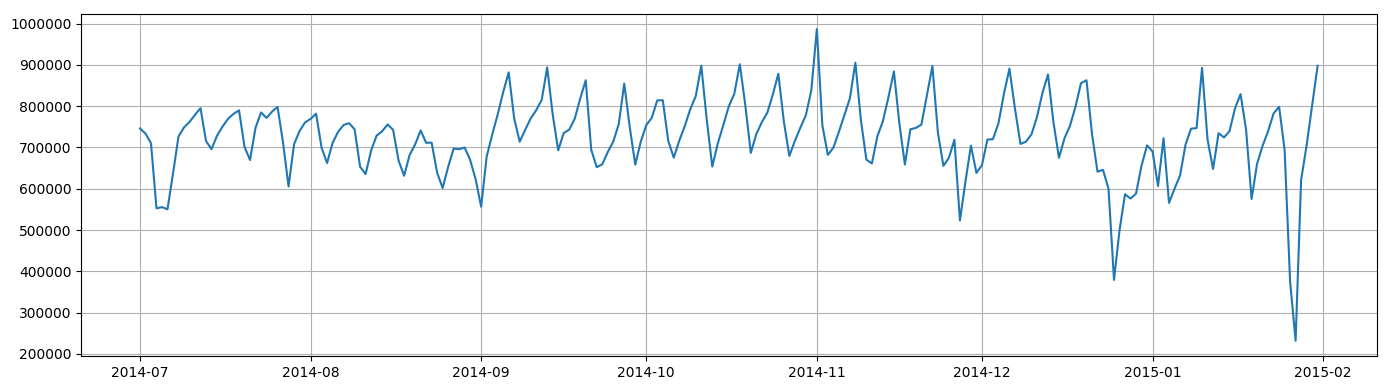

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(data.index, data['value'])

ax.grid()

plt.tight_layout()
plt.show()

### STL Decomposition

This step is not necessary as the S-H-ESD does the STL decomposition implicitly. This is only for visualization purposes.

In [0]:
decomposition = seasonal_decompose(data['value'])

#### Visualization

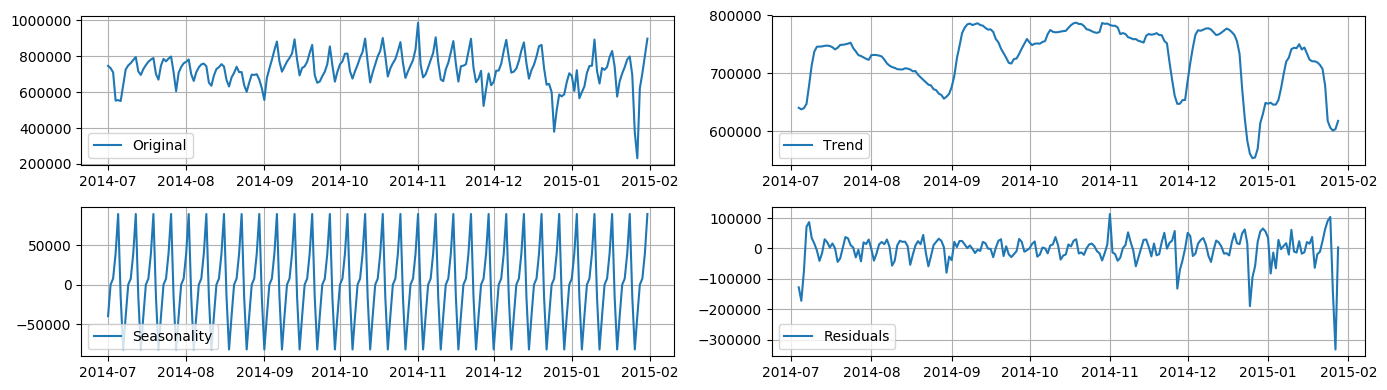

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14, 4))

ax1.plot(data.index, data['value'], label='Original')
ax2.plot(decomposition.trend.index, decomposition.trend, label='Trend')
ax3.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonality')
ax4.plot(decomposition.resid.index, decomposition.resid, label='Residuals')

ax1.grid()
ax1.legend(loc='lower left')

ax2.grid()
ax2.legend(loc='lower left')

ax3.grid()
ax3.legend(loc='lower left')

ax4.grid()
ax4.legend(loc='lower left')

plt.tight_layout()
plt.show()

### Anomaly Detection

In [0]:
k = 10
anomalies = anomaly_detect_ts(data['value'], max_anoms=(k / len(data)), direction='both')['anoms']

#### Anomalies

In [11]:
anomalies.head()

2015-01-27    232058
2014-12-25    379302
2014-12-26    499102
2014-07-05    555470
2015-01-26    375311
dtype: int64

#### Visualization

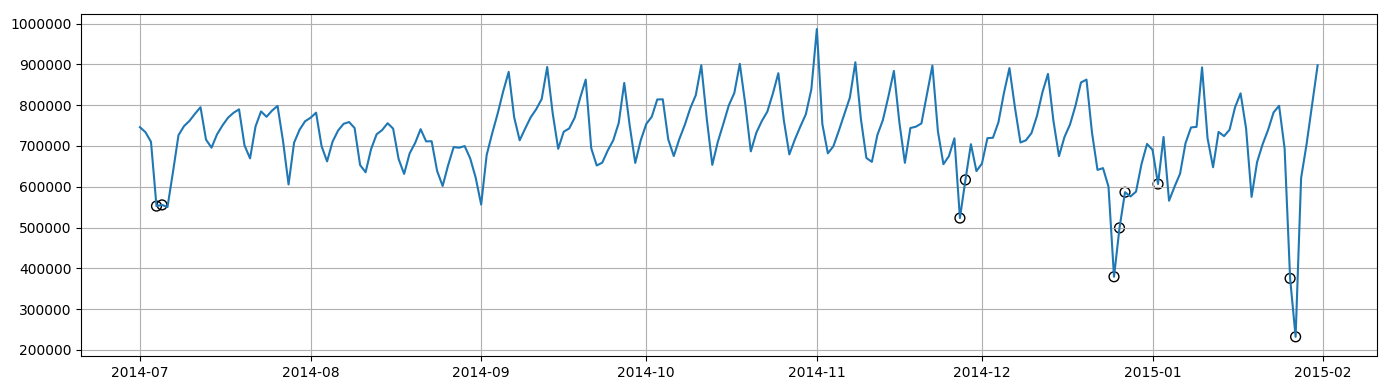

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(data.index, data['value'])
ax.scatter(anomalies.index, anomalies, facecolor='none', edgecolor='k', s=50)

ax.grid()

plt.tight_layout()
plt.show()

## Local Outlier Factor (LOF)

### Data Import

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/dsb/master/Data%20Sets/Demos%20and%20Exercises/fraud_transactions/fraud_transactions.csv')

#### Data Preview

In [14]:
data.head()

,mean_prch_5w,prch_this_w
0,82,74
1,81,84
2,80,127
3,87,80
4,72,75


#### Data Preprocessing

In [0]:
X = data[['mean_prch_5w', 'prch_this_w']].values

#### Visualization

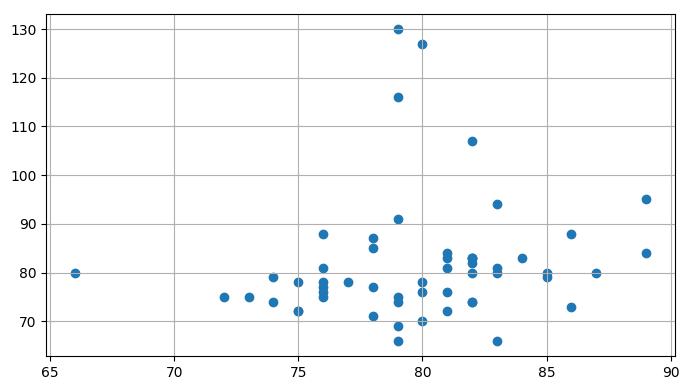

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.scatter(data['mean_prch_5w'], data['prch_this_w'])

ax.grid()

plt.tight_layout()
plt.show()

### Anomaly Detection

In [17]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof.fit(X)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=20,
          p=2)

In [0]:
data['lof'] = lof.negative_outlier_factor_
data['anomaly'] = np.where(data['lof'] < -3, 1, 0)

#### Anomalies

In [19]:
data[data['anomaly'] == 1].head()

,mean_prch_5w,prch_this_w,lof,anomaly
2,80,127,-4.500565,1
16,79,116,-3.544374,1
39,79,130,-4.781535,1


#### Visualization

In [0]:
inliners = data[data['anomaly'] == 0]
outliers = data[data['anomaly'] == 1]

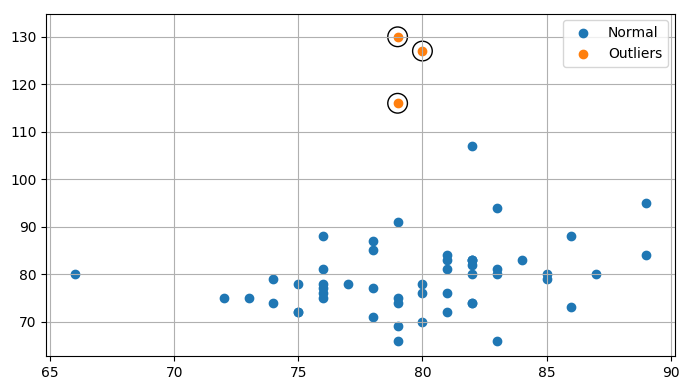

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.scatter(inliners['mean_prch_5w'], inliners['prch_this_w'], label='Normal')
ax.scatter(outliers['mean_prch_5w'], outliers['prch_this_w'], label='Outliers')
ax.scatter(outliers['mean_prch_5w'], outliers['prch_this_w'], facecolor='none', edgecolor='k', s=200, label=None)

ax.grid()
ax.legend()

plt.tight_layout()
plt.show()